In [ ]:
%tensorflow_version 2.x

In [ ]:
import numpy as np
import keras.backend as K
import tensorflow as tf
import operator
from tensorflow import keras
from keras.utils import np_utils

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape, Lambda
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import sequence
from sklearn.metrics.pairwise import cosine_distances

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
import matplotlib.pyplot as plt

import pandas as pd

### Import file

In [ ]:
file_name = 'corpus.txt'
corpus = open(file_name).readlines()

In [ ]:
corpus

['I am Manikesh of IIT Kanpur\n',
 'Myself Keshav of IIT Kanpur \n',
 'You are Keshav of IIT Kanpur \n',
 'He is Manikesh of IIT Kanpur\n',
 'Kanpur is in UP \n',
 'Lucknow is close to Kanpur\n',
 'Lucknow is capital of UP\n']

### Data preprocessing


In [ ]:
# Remove sentences with fewer than 3 words
corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

# Remove punctuation in text and fit tokenizer on entire corpus
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)

# Convert text to sequence of integer values
corpus = tokenizer.texts_to_sequences(corpus)
n_samples = sum(len(s) for s in corpus) # Total number of words in the corpus
V = len(tokenizer.word_index) + 1 # Total number of unique words in the corpus

In [ ]:
n_samples, V

(37, 19)

In [ ]:
corpus

[[9, 10, 5, 2, 3, 1],
 [11, 6, 2, 3, 1],
 [12, 13, 6, 2, 3, 1],
 [14, 4, 5, 2, 3, 1],
 [1, 4, 15, 7],
 [8, 4, 16, 17, 1],
 [8, 4, 18, 2, 7]]

In [ ]:
# Example of how word to integer mapping looks like in the tokenizer
print(list((tokenizer.word_index.items())))

[('kanpur', 1), ('of', 2), ('iit', 3), ('is', 4), ('manikesh', 5), ('keshav', 6), ('up', 7), ('lucknow', 8), ('i', 9), ('am', 10), ('myself', 11), ('you', 12), ('are', 13), ('he', 14), ('in', 15), ('close', 16), ('to', 17), ('capital', 18)]


In [ ]:
# Parameters
window_size = 2 
window_size_corpus = 4

# Set numpy seed for reproducible results
np.random.seed(42)

## CBOW


In [ ]:
from keras.preprocessing import sequence

# Prepare the data for the CBOW model
def generate_data_cbow(corpus, window_size, V):
    all_in = []
    all_out = []

    # Iterate over all sentences
    for sentence in corpus:
        L = len(sentence)
        for index, word in enumerate(sentence):
            start = index - window_size
            end = index + window_size + 1

            # Empty list which will store the context words
            context_words = []
            for i in range(start, end):
                # Skip the 'same' word
                if i != index:
                    # Add a word as a context word if it is within the window size
                    if 0 <= i < L:
                        context_words.append(sentence[i])
                    else:
                        # Pad with zero if there are no words 
                        context_words.append(0)
            # Append the list with context words
            all_in.append(context_words)

            # Add one-hot encoding of the target word
            all_out.append(to_categorical(word, V))
                 
    return (np.array(all_in), np.array(all_out))

For the CBOW model, we generate the training data differently compared to how we did it for the Skipgram model. With the CBOW model, we want to predict words based on their context. We do this by using a window around the word we want to predict. In our code, this window is represented by the `window_size`. All words contained in the window are the context words. Note that if we want to predict the first or final few words of a sentence (depends on the window size), it might be the case that our window reaches the previous or next sentence, respectively. In such a case, the window around the target word is restricted to the words that are in the same sentence. In the code, we solve this by using padding, which ensures that all sequences of context words the same length. For the padding, we simply use a value of 0.

In [ ]:
# Create the training data
X_cbow, y_cbow = generate_data_cbow(corpus, window_size, V)
print(list((tokenizer.word_index.items())))
print('X_cbow = ',X_cbow,'\ny_cbow = ',y_cbow)
print('V = ',V)

[('kanpur', 1), ('of', 2), ('iit', 3), ('is', 4), ('manikesh', 5), ('keshav', 6), ('up', 7), ('lucknow', 8), ('i', 9), ('am', 10), ('myself', 11), ('you', 12), ('are', 13), ('he', 14), ('in', 15), ('close', 16), ('to', 17), ('capital', 18)]
X_cbow =  [[ 0  0 10  5]
 [ 0  9  5  2]
 [ 9 10  2  3]
 [10  5  3  1]
 [ 5  2  1  0]
 [ 2  3  0  0]
 [ 0  0  6  2]
 [ 0 11  2  3]
 [11  6  3  1]
 [ 6  2  1  0]
 [ 2  3  0  0]
 [ 0  0 13  6]
 [ 0 12  6  2]
 [12 13  2  3]
 [13  6  3  1]
 [ 6  2  1  0]
 [ 2  3  0  0]
 [ 0  0  4  5]
 [ 0 14  5  2]
 [14  4  2  3]
 [ 4  5  3  1]
 [ 5  2  1  0]
 [ 2  3  0  0]
 [ 0  0  4 15]
 [ 0  1 15  7]
 [ 1  4  7  0]
 [ 4 15  0  0]
 [ 0  0  4 16]
 [ 0  8 16 17]
 [ 8  4 17  1]
 [ 4 16  1  0]
 [16 17  0  0]
 [ 0  0  4 18]
 [ 0  8 18  2]
 [ 8  4  2  7]
 [ 4 18  7  0]
 [18  2  0  0]] 
y_cbow =  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [

In [ ]:
# Create the CBOW architecture
dim = 2

#for dim in dims:
cbow = Sequential()

    # Add an Embedding layer
cbow.add(Embedding(input_dim=V, 
                   output_dim=dim,
                   input_length=window_size*2, # Note that we now have 2L words for each input entry
                   embeddings_initializer='glorot_uniform'))

cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim, )))

cbow.add(Dense(V, activation='softmax', kernel_initializer='glorot_uniform'))

cbow.compile(optimizer=keras.optimizers.Adam(),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
    
cbow.summary()
print("")
#cbow_models.append(cbow)
#cbow.get_weights()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 4, 2)              38        
_________________________________________________________________
lambda_2 (Lambda)            (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 19)                57        
Total params: 95
Trainable params: 95
Non-trainable params: 0
_________________________________________________________________



In [ ]:
# Train CBOW model
cbow.fit(X_cbow, y_cbow, batch_size=64, epochs=50, verbose=1)
print("")

Epoch 1/50
1/1 [==============================] - 0s 403ms/step - loss: 2.9341 - accuracy: 0.0541
Epoch 2/50
1/1 [==============================] - 0s 6ms/step - loss: 2.9332 - accuracy: 0.0541
Epoch 3/50
1/1 [==============================] - 0s 6ms/step - loss: 2.9323 - accuracy: 0.0541
Epoch 4/50
1/1 [==============================] - 0s 4ms/step - loss: 2.9313 - accuracy: 0.0541
Epoch 5/50
1/1 [==============================] - 0s 4ms/step - loss: 2.9304 - accuracy: 0.0541
Epoch 6/50
1/1 [==============================] - 0s 6ms/step - loss: 2.9294 - accuracy: 0.0541
Epoch 7/50
1/1 [==============================] - 0s 5ms/step - loss: 2.9285 - accuracy: 0.0541
Epoch 8/50
1/1 [==============================] - 0s 6ms/step - loss: 2.9275 - accuracy: 0.0541
Epoch 9/50
1/1 [==============================] - 0s 6ms/step - loss: 2.9266 - accuracy: 0.0541
Epoch 10/50
1/1 [==============================] - 0s 5ms/step - loss: 2.9256 - accuracy: 0.0270
Epoch 11/50
1/1 [====================

In [ ]:
# Save embeddings for vectors of length 50, 150 and 300 using cbow model
weights = cbow.get_weights()

# Get the embedding matrix
embedding = weights[0]

weights



[array([[-0.48724774, -0.17558613],
        [ 0.07577548,  0.14390793],
        [ 0.41947666, -0.26530123],
        [ 0.18717937, -0.14878336],
        [-0.23267516,  0.04003462],
        [-0.01865107, -0.3936736 ],
        [-0.02557449,  0.16233507],
        [ 0.13373378, -0.20747308],
        [-0.5653055 ,  0.11783456],
        [-0.11218169,  0.38029826],
        [-0.40187386, -0.48436177],
        [-0.27289096,  0.02789403],
        [-0.41120037,  0.5335281 ],
        [ 0.54245996, -0.2878798 ],
        [ 0.17485091, -0.12286229],
        [ 0.34241366, -0.20301804],
        [-0.12406819,  0.26509294],
        [-0.26890078,  0.11849216],
        [ 0.1777732 ,  0.47229117]], dtype=float32),
 array([[ 0.18372212,  0.03912233,  0.244791  , -0.30860007, -0.565911  ,
          0.5557085 ,  0.3071963 , -0.23151024, -0.5258235 , -0.11906597,
         -0.12471074, -0.465807  ,  0.3156095 , -0.12478632,  0.43049768,
          0.23465972, -0.08589555, -0.13152845, -0.03636632],
        [ 0.001

In [ ]:
len(corpus)

7

In [ ]:
print(list((tokenizer.word_index.items()))[0][0])

kanpur


In [ ]:
k = embedding[1]

In [ ]:
l = embedding[8]

In [ ]:
embedding[0][0]

-0.48724774

In [ ]:
len(embedding)

19

In [ ]:
len(list((tokenizer.word_index.items())))

18

In [ ]:
words = list((tokenizer.word_index.items()))
words.insert(0,('unkown',0))
words

[('unkown', 0),
 ('kanpur', 1),
 ('of', 2),
 ('iit', 3),
 ('is', 4),
 ('manikesh', 5),
 ('keshav', 6),
 ('up', 7),
 ('lucknow', 8),
 ('i', 9),
 ('am', 10),
 ('myself', 11),
 ('you', 12),
 ('are', 13),
 ('he', 14),
 ('in', 15),
 ('close', 16),
 ('to', 17),
 ('capital', 18)]

In [ ]:
embedding

array([[-0.48724774, -0.17558613],
       [ 0.07577548,  0.14390793],
       [ 0.41947666, -0.26530123],
       [ 0.18717937, -0.14878336],
       [-0.23267516,  0.04003462],
       [-0.01865107, -0.3936736 ],
       [-0.02557449,  0.16233507],
       [ 0.13373378, -0.20747308],
       [-0.5653055 ,  0.11783456],
       [-0.11218169,  0.38029826],
       [-0.40187386, -0.48436177],
       [-0.27289096,  0.02789403],
       [-0.41120037,  0.5335281 ],
       [ 0.54245996, -0.2878798 ],
       [ 0.17485091, -0.12286229],
       [ 0.34241366, -0.20301804],
       [-0.12406819,  0.26509294],
       [-0.26890078,  0.11849216],
       [ 0.1777732 ,  0.47229117]], dtype=float32)

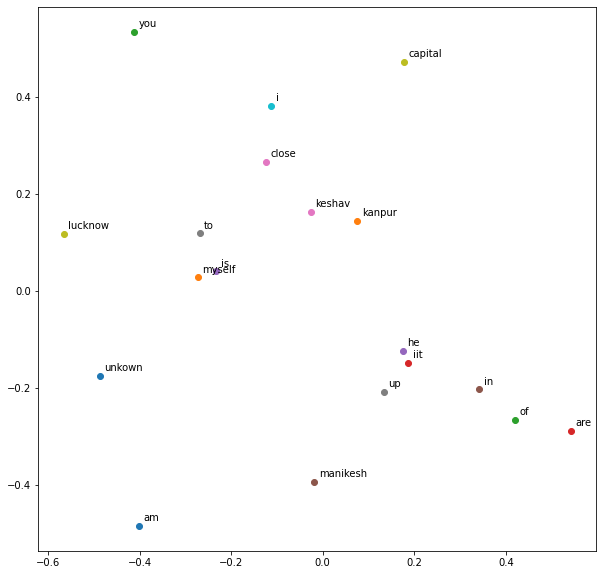

In [ ]:
fig , ax = plt.subplots(1,1,figsize = (10,10))
for i in range(len(embedding)):
  plt.scatter(embedding[i][0],embedding[i][1])
  ax.annotate(words[i][0],(embedding[i][0] + 0.01,embedding[i][1] + 0.01))
plt.show()

In [ ]:
np.linalg.norm(k-l)

0.641611

In [ ]:
# Get word embeddings for each word in the vocabulary, write to file
f = open(f'vectors_cbow_2{len(embedding[0])}.txt', 'w')

# Create columns for the words and the values in the matrix, makes it easier to read as dataframe
columns = ["word"] + [f"value_{i+1}" for i in range(embedding.shape[1])]

# Start writing to the file, start with the column names
f.write(" ".join(columns))
f.write("\n")

for word, i in tokenizer.word_index.items():
  f.write(word)
  f.write(" ")
  f.write(" ".join(map(str, list(embedding[i,:]))))
  f.write("\n")
  f.close()

## Skipgram

In [ ]:
# Prepare data for the skipgram model
def generate_data_skipgram(corpus, window_size, V):
    maxlen = window_size * 2
    all_in = []
    all_out = []
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            p = index - window_size
            n = index + window_size + 1

            in_words = []
            labels = []
            for i in range(p, n):
                if i != index and 0 <= i < L:
                    # Add the input word
                    all_in.append(word)
                    # Add one-hot of the context words
                    all_out.append(to_categorical(words[i], V))

    return (np.array(all_in), np.array(all_out))

We break down each (target word, context word**s**) pair into (target word, context word) pairs. This is done with the `generate_data_skipgram` method above. This method returns two NumPy arrays: `x` (input, i.e., target word) and `y` (output, i.e., context word). We can now use this method to generate our training data.


In [ ]:
# Create training data
X_skip, y_skip = generate_data_skipgram(corpus, window_size, V)
X_skip, y_skip

(array([4, 4, 5, 5, 5, 6, 6, 6, 6, 1, 1, 1, 1, 2, 2, 2, 3, 3, 7, 7, 8, 8,
        8, 1, 1, 1, 1, 2, 2, 2, 3, 3]),
 array([[0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0.,

In [ ]:
# Create skipgram architecture
skipgram_models = []

    # Initialize a Keras Sequential model
skipgram = Sequential()

    # Add an Embedding layer
skipgram.add(Embedding(input_dim=V,
                       output_dim=dim,
                       input_length=1,
                       embeddings_initializer='glorot_uniform'))

    # Add a Reshape layer, which reshapes the output of the embedding layer (1,dim) to (dim,)
skipgram.add(Reshape((dim, )))

    # Add a final Dense layer with the same size as in [1]
skipgram.add(Dense(V, activation='softmax', kernel_initializer='glorot_uniform'))

    # Compile the model with a suitable loss function and select an optimizer.
    # Optimizer Adagrad was used in paper
skipgram.compile(optimizer=keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
skipgram.summary()
print("")
skipgram_models.append(skipgram)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1, 2)              18        
_________________________________________________________________
reshape (Reshape)            (None, 2)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 9)                 27        
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________



We create a list that stores all dimensions (50, 150, and 300). We iterate over this list and create models for each dimension. Note that the base model we created is equal to the model used in Practical 3.1. 

Since we want to predict a context word using a single input word, our `input_length` equals 1. The input dimension simply equals the size of our vocabulary, namely `V`. This is because we use a one-hot encoding. In this one-hot encoding, the index that represents the input word equals 1, and all other indices equal 0. Since we have to consider all words in our vocabulary, the one-hot encoding is of dimension `V`. We do not need to perform the one-hot encoding ourselves for the input data since this is done by the embedding layer in our model.

Since we want to predict a certain context word, which can have `V` possible outcomes, we use a Softmax layer with `V` units such that we can map a probability to each word in `V`. Since our problem is a typical multiclass classification problem, we use **categorical** cross-entropy as our loss function.

We use `adam` as our optimizer, which is an adaptive learning rate optimization algorithm that has been designed specifically for training deep neural networks [2]. We have tried various optimizers, such as SGD, RMSProp, Adam, and Adagrad. Adam seemed to perform the best with respect to the loss and accuracy. We also tried varying the learning rate. We initialize the weights with values from a `glorot_uniform` distribution since we were also requested to use this initializer in Practical 3.1, which tackled a very similar problem compared to the one we are trying to solve in this assignment.

[2] https://arxiv.org/pdf/1412.6980.pdf

In [ ]:
# Training the skipgram models
for skipgram in skipgram_models:
    skipgram.fit(X_skip, y_skip, batch_size=64, epochs=13, verbose=1)
    print("")

We fit each model that considers a varying number of dimensions with a batch size of 64 and 13 epochs. 

We observe that the loss decreases very slowly. Moreover, we observe a slowly increasing accuracy. We use accuracy as a metric, so that we can get sort of an idea of when to stop. The bad thing about our approach is that we train all models for an equal number of epochs this way when that is not necessarily the best course of action, but let us not focus too much on this now as the training does not take that long anyway and we just want to create word embeddings. We used an equal number of epochs for all models to make it easier to compare the losses and accuracies of the different models at equal numbers of epochs. After 12 epochs for the model that considers 50 dimensions, we observe that the accuracy does not increase significantly anymore (even decreases a bit during one epoch). This can also be observed for the model with 150 dimensions after epoch 6. For the model with 300 dimensions, we can already stop after 4 epochs since the accuracy only keeps decreasing. Hence, we observe that training these models for more epochs does not necessarily lead to a better accuracy.

A major reason for this low accuracy is the corpus size being of relatively small size. Our corpus, namely `alice.txt`, has only 26,283 words before processing the file, which is a lot less than the millions of words that are mentioned by Mikolov et al. in [1]. We suspect that this results in our models simply not being able to learn much from our corpus. This is highlighted even more by Mikolov et al. [1] in  tables 2 and 3 in [1]. Since we trained our models on a relatively small corpus, low accuracies were to be expected. Rezaeinia et al. [3] further support this statement. 

[3] https://arxiv.org/ftp/arxiv/papers/1711/1711.08609.pdf

In [ ]:
for skipgram in skipgram_models:
    # Save embeddings for vectors of length 50, 150 and 300 using skipgram model
    weights = skipgram.get_weights()

    # Get the embedding matrix
    embedding = weights[0]

    # Get word embeddings for each word in the vocabulary, write to file
    f = open(f"vectors_skipgram_{len(embedding[0])}.txt", "w")

    # Create columns for the words and the values in the matrix, makes it easier to read as dataframe
    columns = ["word"] + [f"value_{i+1}" for i in range(embedding.shape[1])]

    # Start writing to the file, start with the column names
    f.write(" ".join(columns))

    # Start a new line
    f.write("\n")

    for word, i in tokenizer.word_index.items():
        f.write(word)
        f.write(" ")
        f.write(" ".join(map(str, list(embedding[i,:]))))
        f.write("\n")
    f.close()